## Task is to predict the taxi trip duration 

In [4]:
import os
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from haversine import haversine
import datetime as dt


# Load training data as train
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

train_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train_df.describe()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [6]:
test_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [7]:
train_df.get_dtype_counts()


float64    4
int64      3
object     4
dtype: int64

## Let us look at the target variable distribution 

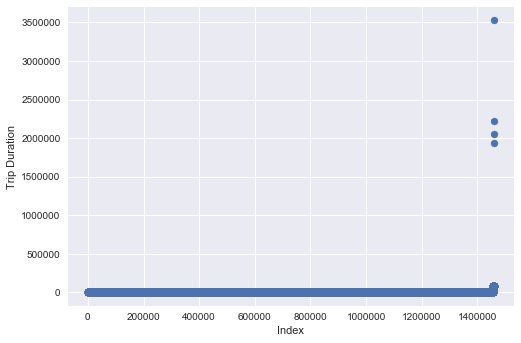

In [8]:
plt.scatter(range(train_df.shape[0]),np.sort(train_df['trip_duration']))
plt.xlabel('Index')
plt.ylabel('Trip Duration')
plt.show()

### We see outliers for trip duration greater than 500,000. Let us get rid of this.

In [9]:
train_new_df = train_df[train_df.trip_duration < 500000]

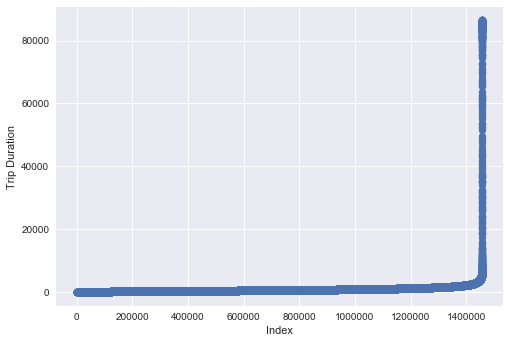

In [10]:
plt.scatter(range(train_new_df.shape[0]),np.sort(train_new_df['trip_duration']))
plt.xlabel('Index')
plt.ylabel('Trip Duration')
plt.show()

##  Let us look at the relationship between train and test pickup locations 

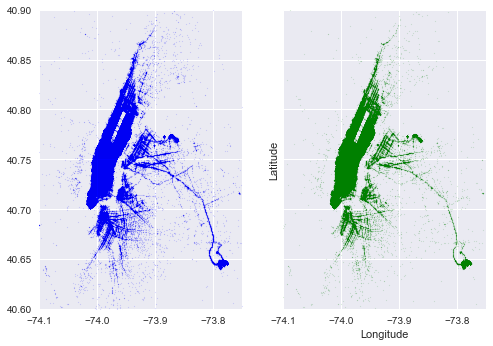

In [11]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
long_border = (-74.1, -73.75)
lat_border = (40.6, 40.9)
plt.ylim(lat_border)
plt.xlim(long_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[0].scatter(train_new_df.pickup_longitude,train_new_df.pickup_latitude,color='blue',s=1,alpha=0.1)
ax[1].scatter(test_df.pickup_longitude,test_df.pickup_latitude,color='green',s=1,alpha=0.1)
plt.show()

### We see a lot of correlation between train and test pickup locations so we should be able to use the train data effectively. 

Pickup/dropoff location can be clustered using KMeans to provide additional features

In [12]:
from sklearn.cluster import MiniBatchKMeans

X = np.vstack((train_new_df[['pickup_latitude', 'pickup_longitude']], 
               train_new_df[['dropoff_latitude', 'dropoff_longitude']]))

# Remove abnormal locations
min_lat, min_lng = X.mean(axis=0) - X.std(axis=0)
max_lat, max_lng = X.mean(axis=0) + X.std(axis=0)
X = X[(X[:,0] > min_lat) & (X[:,0] < max_lat) & (X[:,1] > min_lng) & (X[:,1] < max_lng)]

kmeans = MiniBatchKMeans(n_clusters=15, batch_size=32).fit(X)

train_new_df.loc[:,'pickup_cluster']  = kmeans.predict(train_new_df[['pickup_latitude', 'pickup_longitude']])
train_new_df.loc[:,'dropoff_cluster'] = kmeans.predict(train_new_df[['dropoff_latitude', 'dropoff_longitude']])

C:\Users\takalyan\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\takalyan\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Let us look at how the clusters map to the lat/long

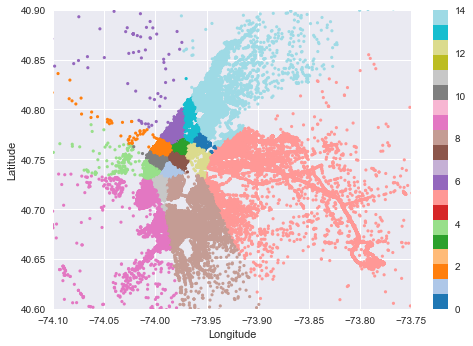

In [13]:
long_border = (-74.1, -73.75)
lat_border = (40.6, 40.9)
plt.ylim(lat_border)
plt.xlim(long_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
scat = plt.scatter(train_new_df.pickup_longitude,train_new_df.pickup_latitude,\
            c=train_new_df.pickup_cluster,label=train_new_df.pickup_cluster,cmap='tab20',s=10, lw=0,)
plt.colorbar(scat)
plt.show()

### Plot the cluster vs trip duration

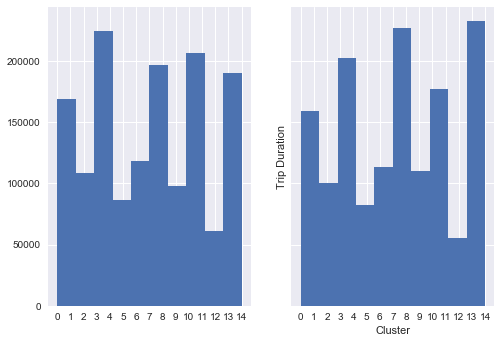

In [14]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True)
plt.xlabel('Cluster')
plt.ylabel('Trip Duration')
ax[0].hist(train_new_df.pickup_cluster)
ax[1].hist(train_new_df.dropoff_cluster)
ax[0].set_xticks(np.arange(15))
plt.show()


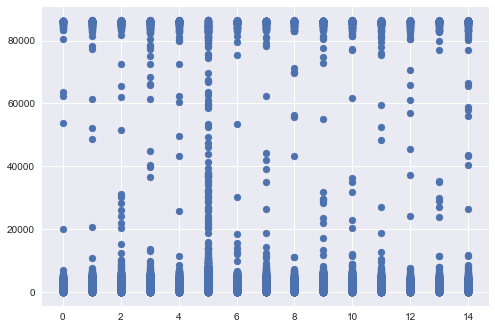

In [15]:
plt.scatter(train_new_df.pickup_cluster,train_new_df.trip_duration)
plt.show()

## Let us look at the distribution of pickup hour (0-24) vs day of the week (0-6)

C:\Users\takalyan\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\takalyan\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


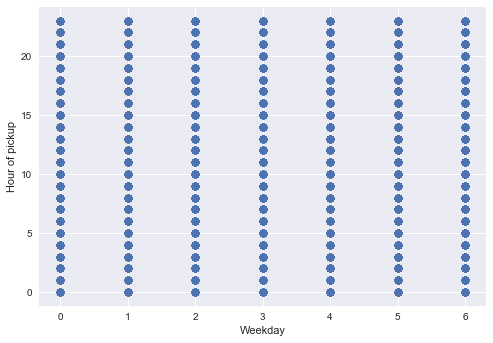

In [16]:
date_time = pd.to_datetime(train_new_df.pickup_datetime)
train_new_df.loc[:,'weekday'] = date_time.dt.weekday
train_new_df.loc[:,'hour'] = date_time.dt.hour
train_new_df.loc[:,'month'] = date_time.dt.month

plt.scatter(train_new_df.weekday,train_new_df.hour)
plt.xlabel('Weekday')
plt.ylabel('Hour of pickup')
plt.show()

date_time = pd.to_datetime(test_df.pickup_datetime)
test_df.loc[:,'month'] = date_time.dt.month


#### There is almost an equal distribution of hour of pickup across the week. 

### Let us look at the histogram for the months for train/test set

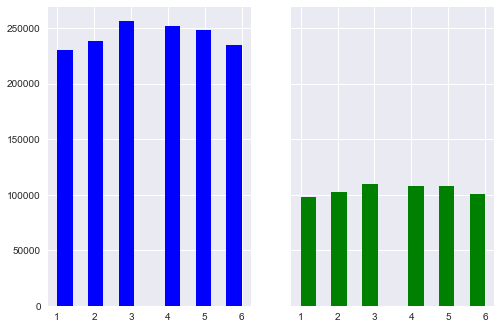

In [17]:
fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True)

ax[0].hist(train_new_df.month,12,color='blue')
ax[1].hist(test_df.month,12,color='green')
plt.show()

#### There is an overlap of months for train/test set so the month feature will be useful

### Let us look at the trip duration w.r.t month of transit

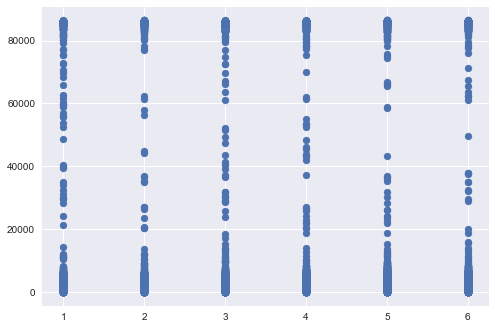

In [18]:
plt.scatter(train_new_df.month,train_new_df.trip_duration)
plt.show()

### Correlation 

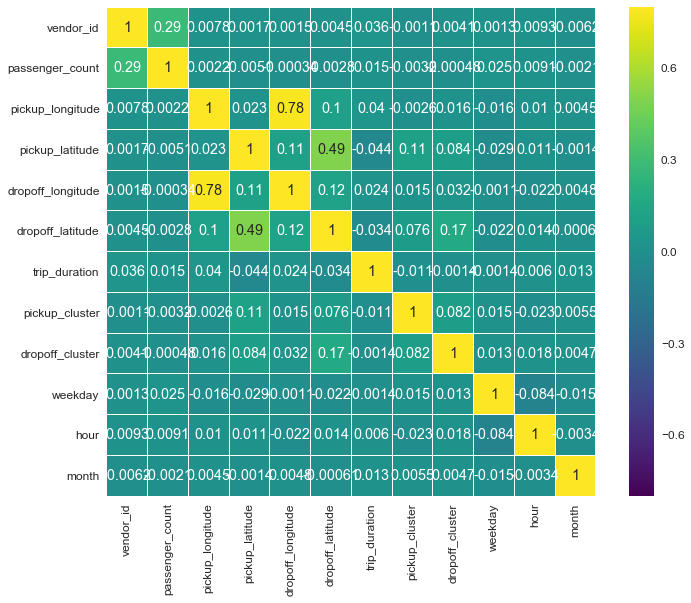

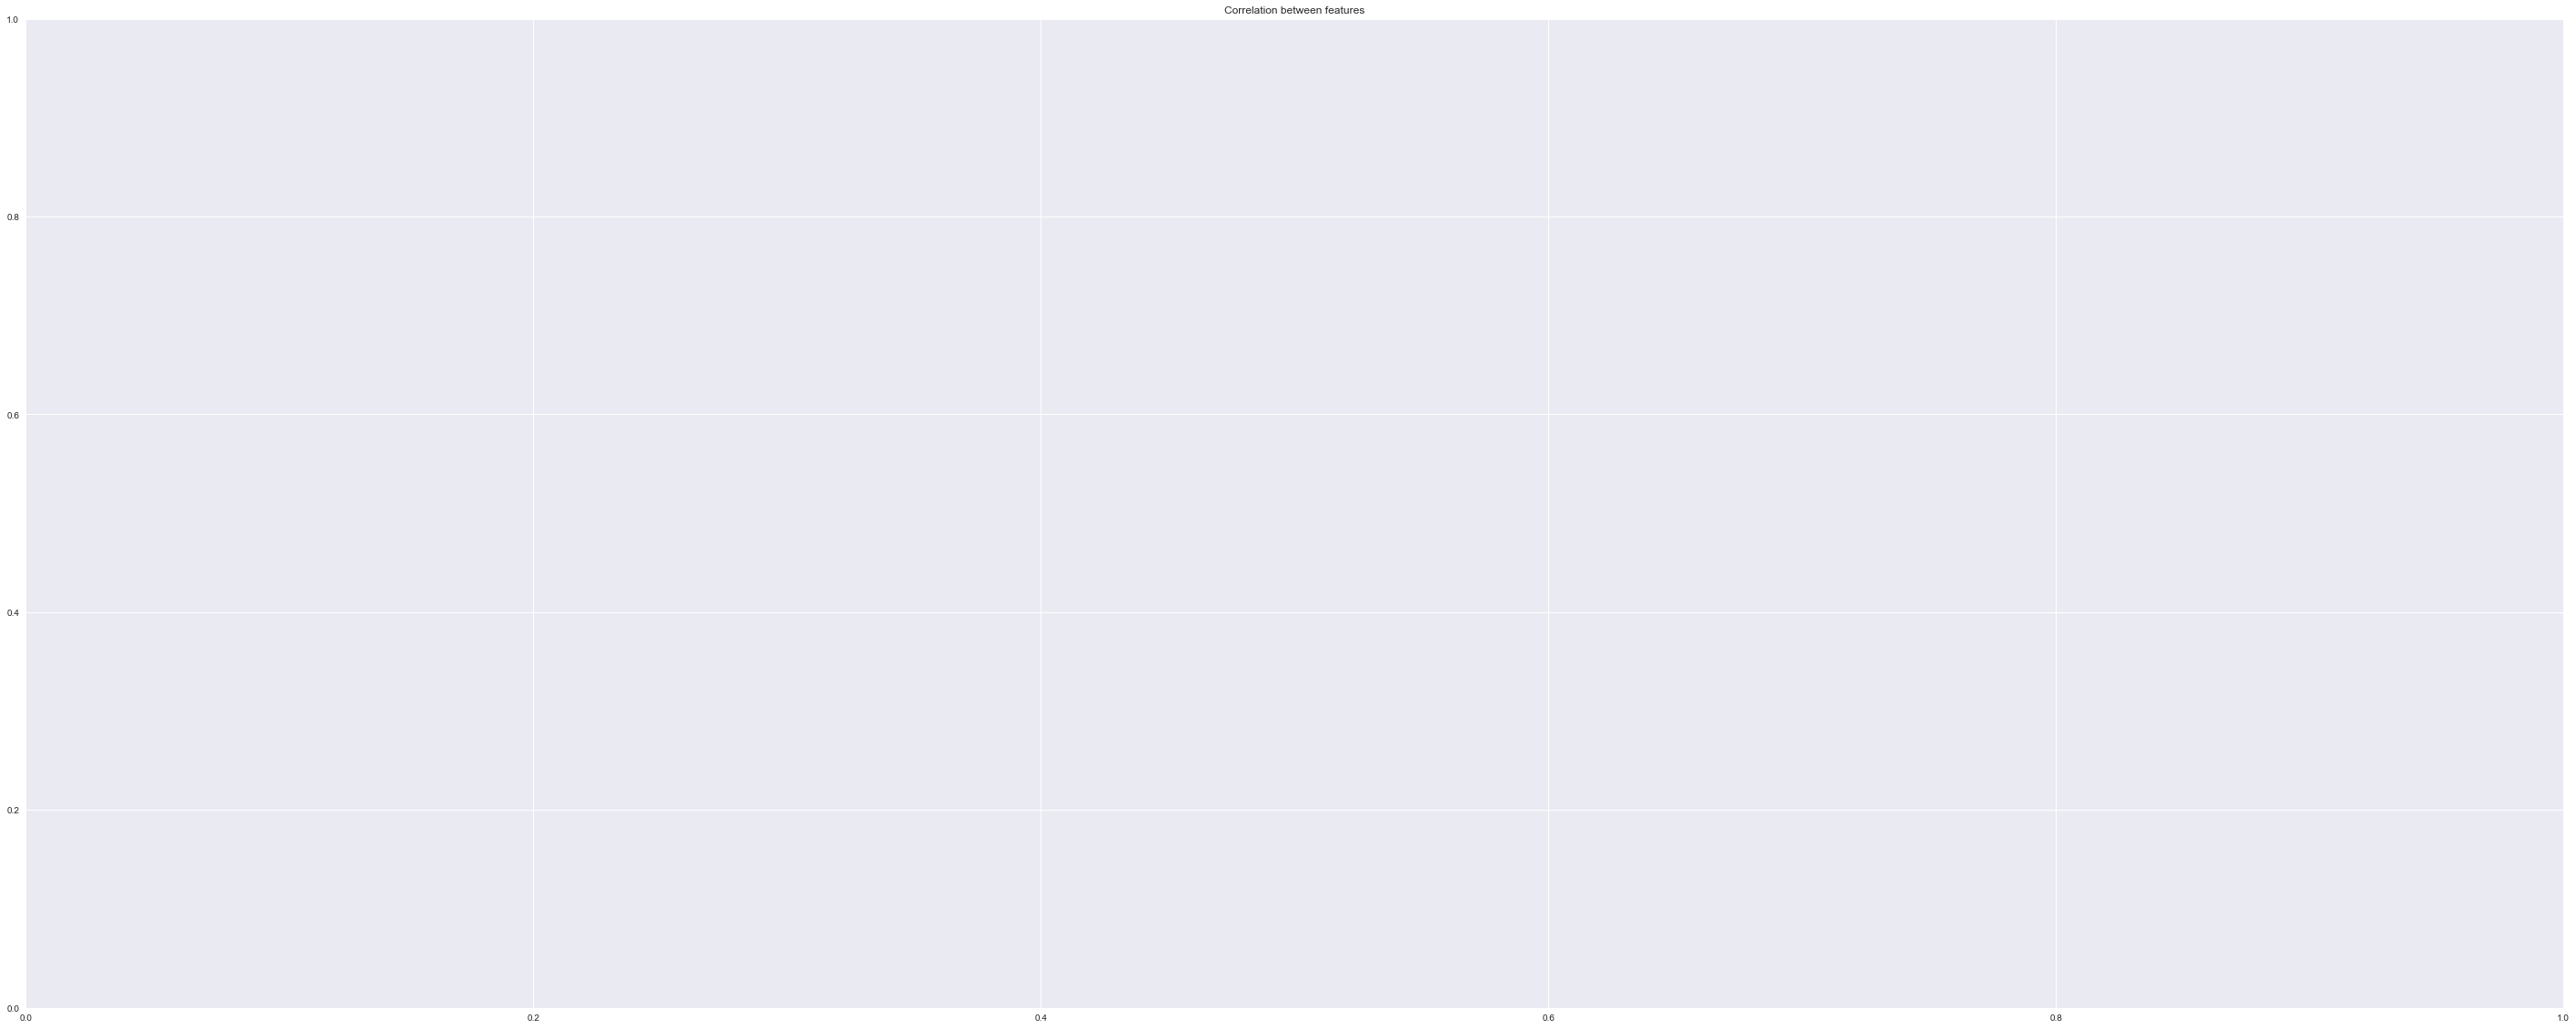

In [36]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train_new_df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.figure(figsize=(50, 20))
plt.title('Correlation between features');
plt.show()
